## Function Approximation
- In stochastic models, the policy or value functions are unkown

- But, we can numerically solve these functions on a finite set of grid points

- Most of the time, we need the value of these functions outside of the grid points

    - To better approach the true policy functions (think about the BFGS)
    
    - To apply more sophisticated and efficient methods (optimization, root-finding, etc.)

*Approximation* is the way we can compute the value of a function outside of the grid points!

### 1. Notation
Let's $\mathcal{F}$ be the space of continuous real-valued function with domain $X\subset\mathbb{R}$, and define the inner product operation
$$
<g,h> = \int_{X} g(x) h(x) w(x) dx,
$$
where $g,h,w\in\mathcal{F}$ and $w$ is a weighting function. 

Suppose we want to approximate a function $f:X\to\mathbb{R}$ with
$$
f(x) \approx \tilde{f} (x,\Lambda) \equiv \sum_{i=0}^{n-1} \lambda_i \psi_i (x),
$$
where $\Lambda$ is an n-dimensional vector with entries $\lambda_i\in\mathbb{R}$ and $\psi_i\subset\mathcal{F}$ is a set of known-basis function. We have reduced the representation of a potentially infinite dimensional object to a finite element pair $\lambda_i, \psi_i$.

Define a residual function at each point $x\in X$:
$$
\mathcal{R} (x,\Lambda) = f(x) - \tilde{f} (x,\Lambda)
$$

The goal is to find $\Lambda$ that makes the residual function as small as possible!

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size' : 20, 'lines.linewidth' : 3.5, 'figure.figsize' : (13,7)})

Consider the following values of an unknown function $f(x)$ 

In [2]:
x = np.array([0, 1, 2, 3, 4, 5, 6])
f = np.array([0, 0.8415, 0.9093, 0.1411, -0.7568, -0.9589, -0.2794])

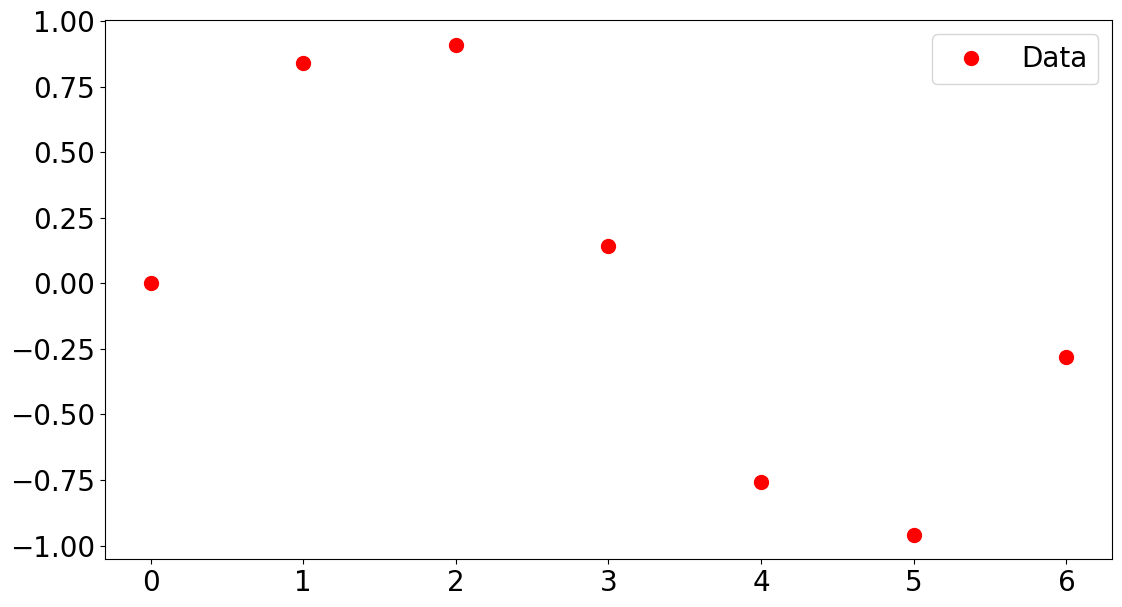

In [3]:
fig, ax = plt.subplots()
ax.plot(x, f, 'ro', label='Data', markersize=10)
ax.legend();

There are two approaches to choose $\tilde{f} (x,\Lambda)$:

- Collocation: Set $\mathcal{R} (x,\Lambda)=0$ at exactly $n$ points

- Regression: Minimize the sum of squared errors

It is impossible to set $\mathcal{R} (x,\Lambda)=0$ for all $x\in X$.

### 2. Collocation Method
We want to find $\tilde{f} (x_i,\Lambda)$ at exactly $n$ points such that:
$$
\mathcal{R} (x_i,\Lambda)=f(x_i) - \tilde{f} (x_i,\Lambda) = \begin{cases}
    f(x_1) - \sum_{i=0}^{n-1} \lambda_i \psi_i (x_1) & = 0\\
    f(x_2) - \sum_{i=0}^{n-1} \lambda_i \psi_i (x_2) & = 0\\
     & \vdots \\
    f(x_n) - \sum_{i=0}^{n-1} \lambda_i \psi_i (x_n) & = 0
  \end{cases} \tag{1}
$$

Once we choose the basis function $\psi_i (x)$, we can solve for the $\lambda_i^*$ using the equation above.

Different options to choose the basis function:

1. Nearest-neighbor interpolation

2. Linear interpolation

3. Polynomial interpolation

4. Spline interpolation

### 2.1. Nearest-neighbor interpolation
The simplest interpolation method is to locate the nearest data value, and assign the same value.

Set $\lambda=1$ and $\psi_i = f(x_i)$ for $\displaystyle x\in\left[\frac{x_{i-1}+x_i}{2},\frac{x_i+x_{i+1}}{2}\right)$

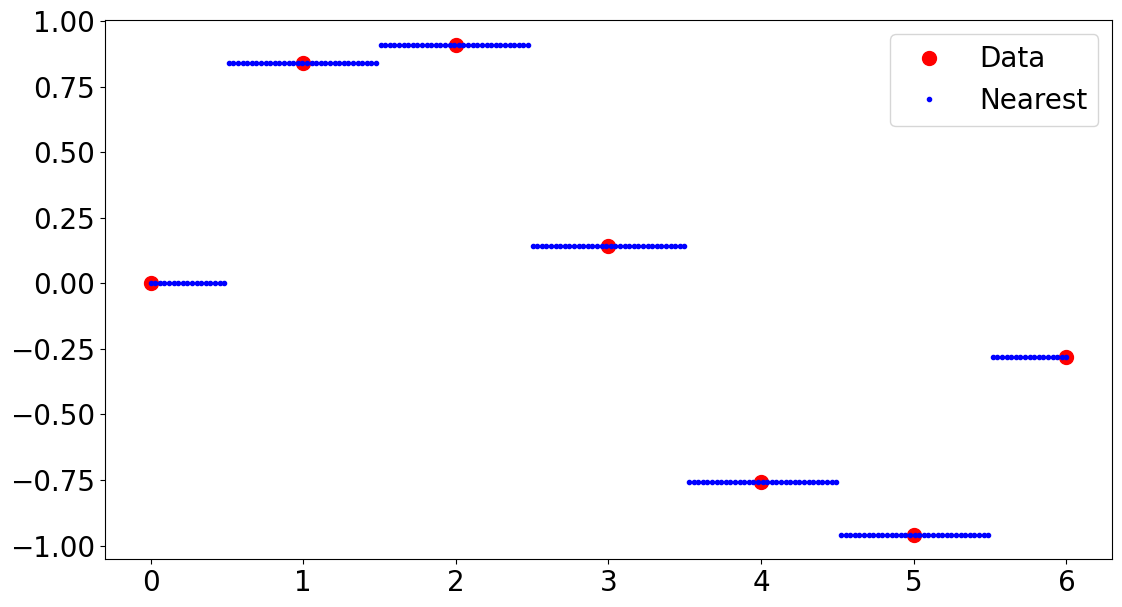

In [4]:
# Nearest-neighbor
nn_fun = interp1d(x, f, kind='nearest')

# Define our n points
npoints = np.linspace(x.min(), x.max(), 200)

fig, ax = plt.subplots()
ax.plot(x, f, 'ro', label='Data', markersize=10)
ax.plot(npoints, nn_fun(npoints), 'b.', label='Nearest')
ax.legend();

**Advantages**
- Very simple and fast

**Disadvantages**
- Very raw idea
- Non-continuous function

### 2.2. Linear interpolation
One of the simplest methods is linear interpolation.

Set $\lambda=1$ and $\displaystyle \psi_i = f(x_i) + (f(x_{i+1}) - f(x_i)) \frac{x-x_i}{x_{i+1}-x_i}$ for $x\in [x_i,x_{i+1}]$

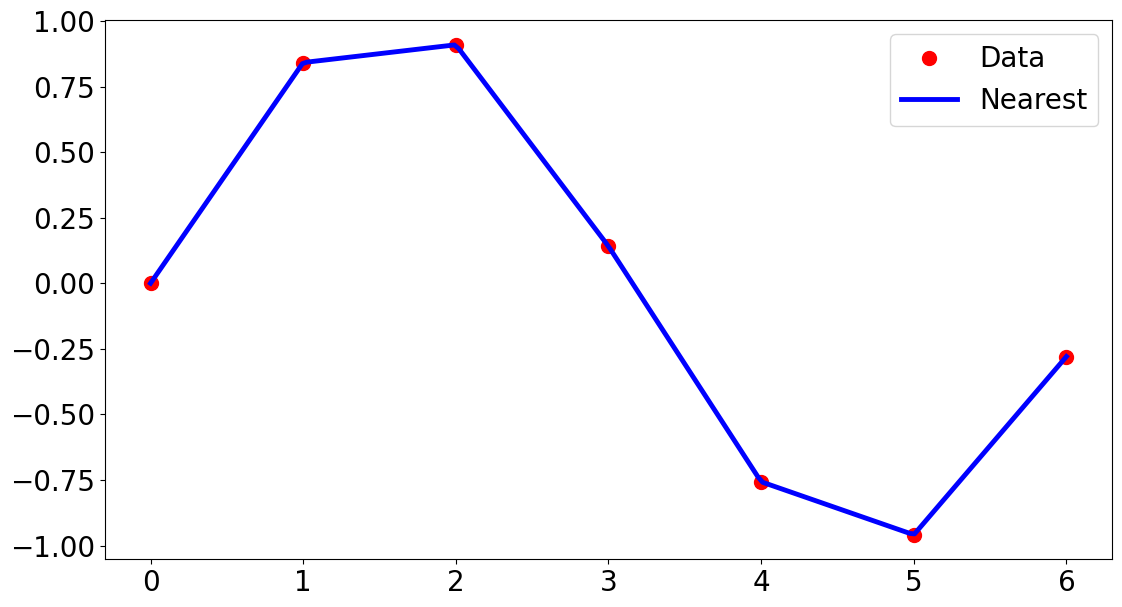

In [5]:
# Linear interpolation
lin_fun = interp1d(x, f, kind='linear') # you can also use the np.interp function (try it!)

fig, ax = plt.subplots()
ax.plot(x, f, 'ro', label='Data', markersize=10)
ax.plot(npoints, lin_fun(npoints), 'b-', label='Nearest')
ax.legend();

**Advantages**
- Very fast
- Preserves weak concavity and monotonicity
- Extrapolation properties are well-behaved
- It is well-known
- Easy to integrate
- Easily generalized to multi-dimensional cases
- Local: only the nearest values need to be known to interpolate

**Disadvantages**
- Doesn't preserve differentiability
- Biased for strictly concave/convex functions

### 2.3. Polynomial interpolation
It is a way to produce a *differentiable* and *smooth* approximating function.

Let's consider the case where the number of points ($n$) is equal to the order of the polynomial minus 1 ($n-1$) and equal to the number of nodes for the polynomial ($n$).

With regular polynomials with degree $n-1$, we have:
$$
\psi_i (x) = 1 + x + x^2 + \cdots + x^{n-1}.
$$

The system of equations derived from the collocation method shown in equation (1) can be written as
$$
F - M\Lambda = 0, \tag{2}
$$
where $F$ is the $n\times 1$ vector with entries $f(x_i)$, $\Lambda$ is a $n\times 1$ vector and $M$ is a $n\times n$ matrix
$$
M = \begin{pmatrix}
\psi_0 (x_1) & \psi_1 (x_1) & \cdots & \psi_{n-1} (x_1) \\
\psi_0 (x_2) & \psi_1 (x_2) & \cdots & \psi_{n-1} (x_2) \\
\vdots & \vdots & \ddots & \vdots \\
\psi_0 (x_n) & \psi_1 (x_n) & \cdots & \psi_{n-1} (x_n)
\end{pmatrix}
$$

Assuming the points $x$ are known, equation (2) can easily be solved for $\Lambda^*$ with $n$ equations and $n$ unknowns:
$$
\Lambda^* = M^{-1} F
$$

Once we solve for $\Lambda^*$, the approximate function value at *any* point $x\in X$ becomes
$$
\tilde{f} (x,\Lambda^*) = \sum_{i=0}^{n-1} \lambda_i^* \psi_i(x)
$$

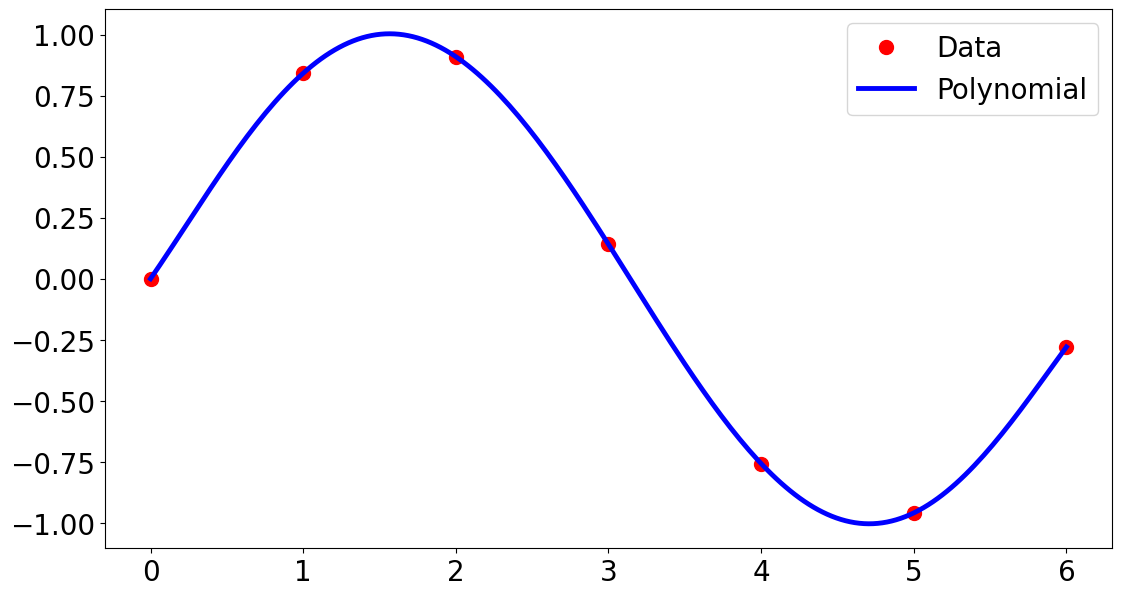

In [6]:
import functions

fig, ax = plt.subplots()
ax.plot(x, f, 'ro', label='Data', markersize=10)
ax.plot(npoints, functions.pol_interp(x,f,npoints), 'b-', label='Polynomial')
ax.legend();

**Advantages**
- Preserves concavity, monotonicity and differentiability 
- Regular polynomials are well-known
- Easy to understand

**Disadvantages**
- Difficult to solve as the number of points $n$ increases
    - As $n$ gets larger, $M$ gets closer to become a singular matrix

### 3. Regression

**What if we have more data points than the order of the polynomial?**

Suppose we have $n$ points and the order of the polynomial is $m-1$, where $n>m-1$. That is, we have more equations ($n$) than unknowns ($m-1$) to solve for.

In this case, we can solve for $\Lambda^*$ minimizing the sum of squared errors:
$$
\Lambda^* = \argmin \int_{X} \mathcal{R} (x_i,\Lambda)^2 dx
$$

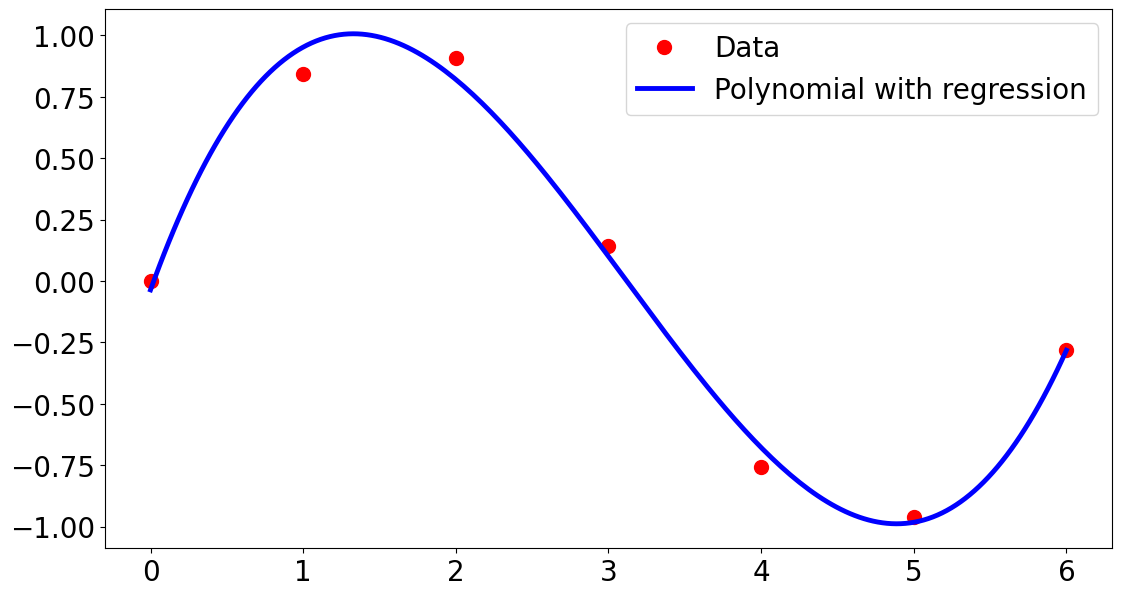

In [7]:
fig, ax = plt.subplots()
ax.plot(x, f, 'ro', label='Data', markersize=10)
ax.plot(npoints, functions.pol_interp_ols(x,f,npoints,4), 'b-', label='Polynomial with regression')
ax.legend();

### 2.4. Spline interpolation

Let's consider the function $s:[a,b]\to\mathbb{R}$

**Definition.** $s(x)$ is a spline of order $n$ is $s$ is $C^{n-2}$ on $[a,b]$ and there is a grid of points (called nodes) $a=x_0<x_1<\ldots,x_m=b$ such that $s(x)$ is a polynomial of degree $n-1$ on each subinterval $[x_i,x_{i+1}]$ (Judd, 1998). 

A regular polynomial interpolation uses *one* high-order polynomial for the entire domain $[a,b]$.

Spline of different orders go by different names:

1. **Linear spline/interpolant** (order 2): linear interpolant, it is $C^0$ globally and uses polynomials of degree 1 (linear) in each interval.

2. **Quadratic spline** (order 3): each interval is a parabola and the entire spline is $C^1$.

3. **Cubic spline** (order 4): each interval is a cubic and the entire spline is $C^2$.

### 2.4.1. Cubic spline
$s(x)$ is assumed to be a cubic polynomial:
$$
s_i (x) = a_i + b_ix + c_i x^2 + d_i x^3, \qquad \forall x\in[x_i,x_{i+1}]
$$

Now, for each interval we have 4 unknowns $\{a_i,b_i,c_i,d_i\}$. With $n$ data points, we have $4(n-1)$ unknowns, so we need $4(n-1)$ equations.
- $n$ equations come from the definition of the function:
$$
s_i (x_i) = a_i + b_ix_i + c_i x_i^2 + d_i x_i^3
$$
- $n-2$ equations come from the continuity assumption (doesn't exist for the end points):
\begin{align*}
s_i (x_{i+1}) &= s_{i+1} (x_{i+1}) \\
a_i + b_ix_{i+1} + c_i x_{i+1}^2 + d_i x_{i+1}^3 &= a_{i+1} + b_{i+1} x_{i+1} + c_{i+1} x_{i+1}^2 + d_{i+1} x_{i+1}^3
\end{align*}
- $n-2$ equations come from the $C^1$ assumption:
\begin{align*}
s_i' (x_{i+1}) &= s_{i+1}' (x_{i+1}) \\
b_i + 2c_i x_{i+1} + 3d_i x_{i+1}^2 &= b_{i+1} + 2c_{i+1} x_{i+1} + 3d_{i+1} x_{i+1}^2
\end{align*}
- $n-2$ equations come from the $C^2$ assumption:
\begin{align*}
s_i'' (x_{i+1}) &= s_{i+1}'' (x_{i+1}) \\
2c_i + 6d_i x_{i+1} &=  2c_{i+1}  + 6d_{i+1} x_{i+1}
\end{align*}
- This gives us $4(n-1)-2$ equations in total. We still need 2 more equations. Optional ways to choose these 2 equations:
    - Natural splines: $s_1' (x_1) = s_{n-1}'(x_n) = 0$. This minimizes the total curvature of the spline.
    - Hermite splines.

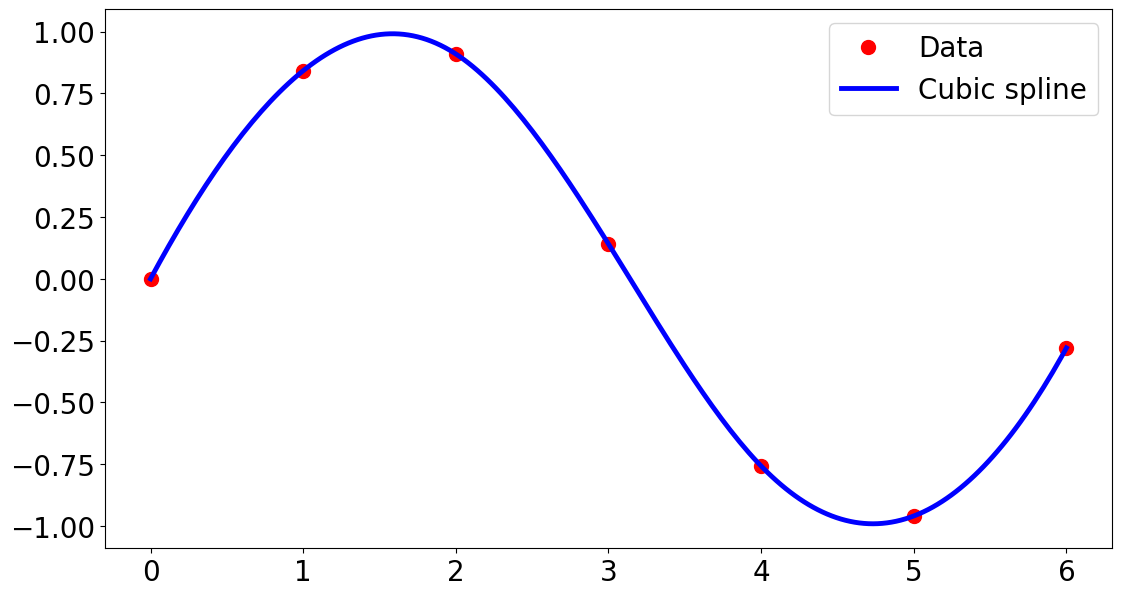

In [8]:
# Cubic spline interpolation
cubic_spl = interp1d(x, f, kind='cubic') # You can also use the np.interp function (try it!)

fig, ax = plt.subplots()
ax.plot(x, f, 'ro', label='Data', markersize=10)
ax.plot(npoints, cubic_spl(npoints), 'b-', label='Cubic spline')
ax.legend();

**Advantages**
- Cubic splines have very good convergence properties for smooth functions as the number of knots increase

**Disadvantages**
- They respond to extreme data by introducing extra oscillation
- Extra oscillation introduces local minima/maxima

## Endogenous Grid Method
Let's go back to *stochastic neoclassical growth model* with full capital depreciation ($\delta=1$), with $t$ subscripts added:

\begin{gather*}
    \mathbb{V}_t(z,k) = \max_{c,k'} \left\{ u(c) + \beta \mathbb{E} [\mathbb{V}_{t+1}(z',k')|z] \right\} \\
    \text{s.t.} \quad c + k' = z k^{\alpha}, \\
    c>0, k>0
\end{gather*}

Optimal policy characterized by two conditions:

**Envelope condition**:
$$
V_{k,t}(z,k) = (z\alpha k^{\alpha-1}) u'(c_t(z,k)) \tag{3}
$$

**First-order condition**:

$$
u'(c_t(z,k)) = \beta \mathbb{E}[V_{k,t+1}(z',k_t'(z,k))|z] \tag{4}
$$

More efficient and accurate to use (3) and (4) to iterate directly on $V_k$ than to do standard value function iteration ([Carroll, C. D. (2006), "The method of endogenous gridpoints for solving dynamic stochastic optimization problems"](https://doi.org/10.1016/j.econlet.2005.09.013))

**Step 1. Discounting and expectations** 

Define "end-of-period" value function $W_t$ as
$$
W_t(z,k') \equiv \beta \mathbb{E}[V_{t+1}(z',k')|z],
$$

so that (4) simplifies to 
$$
u'(c_t(z,k)) = W_{k,t}(z,k'). \tag{5}
$$


**Step 2. Solve for capital policy using the FOC**

Define $k_t(z,k')$ to be inverse of $k_t'(z,k)$, i.e. $k_t(z,k_t'(z,k))\equiv k$, so (5) can be re-written as

$$
c_t(z,k_t(z,k')) = \underbrace{(u')^{-1}(W_{k,t}(z,k'))}_{\equiv c_t^{endog}(z,k')} \tag{6}
$$

This is time-$t$ consumption at the so-called **endogenous gridpoint** $(z,k_t(z,k'))=(z,k')$, which is at whatever cash-on-hand level today that makes the household choose capital $k'$ tomorrow. With $u(c) \equiv \frac{c^{1-\sigma^{-1}}}{1-\sigma^{-1}}$, we have that so that $(u')^{-1}(x) = x^{-\sigma}$


This must obey budget constraint, where we define **cash on hand** to be $coh_t(z,k)\equiv zk^{\alpha}$:

$$
c_t^{endog}(z,k')+k' = coh_t(z,k_t(z,k'))  \tag{7}
$$

We can isolate $k_t(z,k')$ by writing 
$$
k_t(z,k') = \left( \frac{c_t^{endog}(z,k')+k'}{z} \right)^{1/\alpha}
$$

**Interpolation step.** Ultimately, though, we want the inverse (holding $z$ fixed) of this function, $k_t'(z,k)$, defined on our regular grid

Given $k_t(z,k')$, the easiest way to get that inverse is to evaluate $(k_t(z,k'),k')$ on the grid of all $k'$ for a given $z$, treating these as *sample points* from the function $k_t'(s,k)$, and then to *linearly interpolate* to evaluate $k_t'(s,k)$ on our grid of $k$

**Step 3. Calculate consumption and new value function**

Given the calculated capital policy function $k_t'(s,k)$, we can compute the consumption policy function as:
$$
c_t(z,k) = coh_t(z,k) - k_t'(s,k).
$$

We can also compute the new value function using (3):
$$
V_{k,t}(z,k) = (z\alpha k^{\alpha-1}) u'(c_t(z,k)) 
$$

**Step 4. Obtain the steady-state policy functions**

Iterate backward the value function until convergence criterion hit

In [9]:
# Baseline parameters
sigma   = 1
beta    = 0.97
alpha   = 0.33

# Technology process
rho_z   = 0.95
sigma_z = 0.03
n_z     = 7

# Capital grid
kmin    = 0.01
kmax    = 5
n_k     = 50

In [10]:
# Import functions from the previous lecture
import make_grids

k_grid = make_grids.discretize_capital_exponential(kmin, kmax, n_k)
z_grid, piz, Piz = make_grids.markov_rouwenhorst(rho_z, sigma_z, n_z)

In [11]:
def egm(Vk, Piz, k_grid, z_grid, beta, sigma, alpha):
    # Step 1
    Wk = (beta * Piz) @ Vk
    
    # Step 2
    c_endog = Wk**(-sigma)
    k_inv   = ((c_endog + k_grid[np.newaxis, :]) / z_grid[:, np.newaxis]) ** (1/alpha)
    coh = z_grid[:, np.newaxis] * (k_grid[np.newaxis, :] ** alpha) 
    
    # Interpolation step
    gk = np.empty_like(k_inv)
    for z in range(len(z_grid)):
        gk[z, :] = np.interp(k_grid, k_inv[z,:], k_grid)
    
    # Step 3
    gc = coh - gk
    Vk = (z_grid[:, np.newaxis] * alpha * (k_grid[np.newaxis, :] ** (alpha-1))) *gc**(-1/sigma)
    
    return Vk, gk, gc

In [12]:
def policy_ss(Piz, k_grid, z_grid, beta, sigma, alpha, tol=1E-9):
    # Initial guess for Vk
    coh = z_grid[:, np.newaxis] * k_grid[np.newaxis, :] ** alpha
    Vk = (0.02*coh) ** (-1/sigma)
    
    # Iterate until maximum distance between two iterations falls below tol (fail-safe max of 10,000 iterations)
    for it in range(10_000):
        Vk, gk, gc = egm(Vk, Piz, k_grid, z_grid, beta, sigma, alpha)
        
        # After iteration 0, can compare new policy function to old one
        if it > 0 and np.max(np.abs(Vk - V_old)) < tol:
            return Vk, gk, gc
        
        V_old = Vk

In [13]:
Vy, gk, gc = policy_ss(Piz, k_grid, z_grid, beta, sigma, alpha)

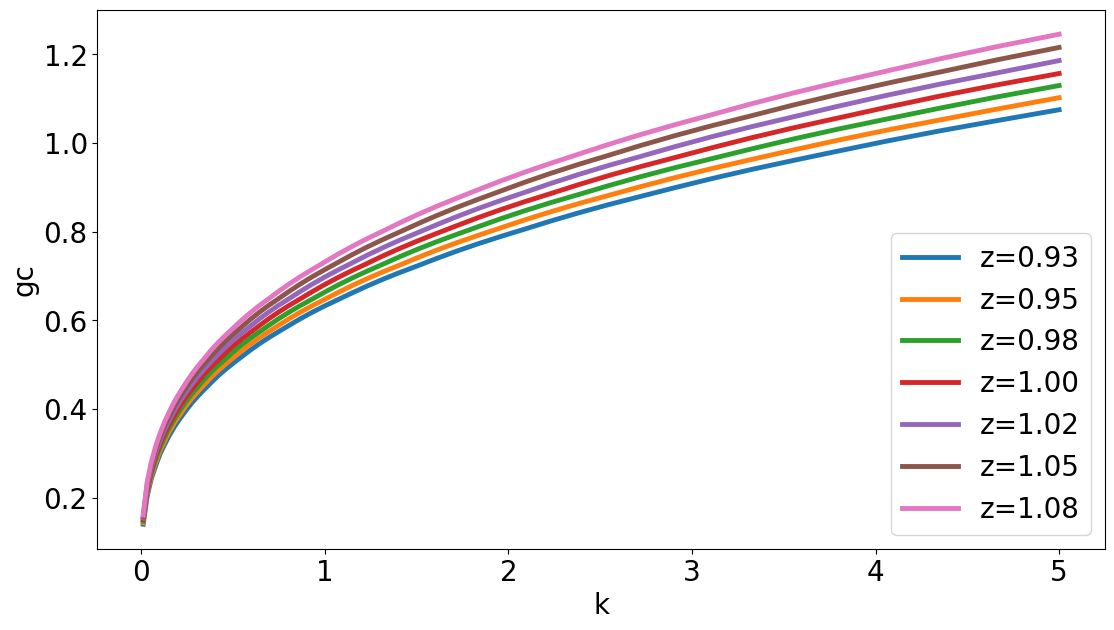

In [14]:
for s, zs in enumerate(z_grid):
    plt.plot(k_grid, gc[s, :], label=f'z={zs:.2f}')
plt.legend()
plt.xlabel('k')
plt.ylabel('gc');

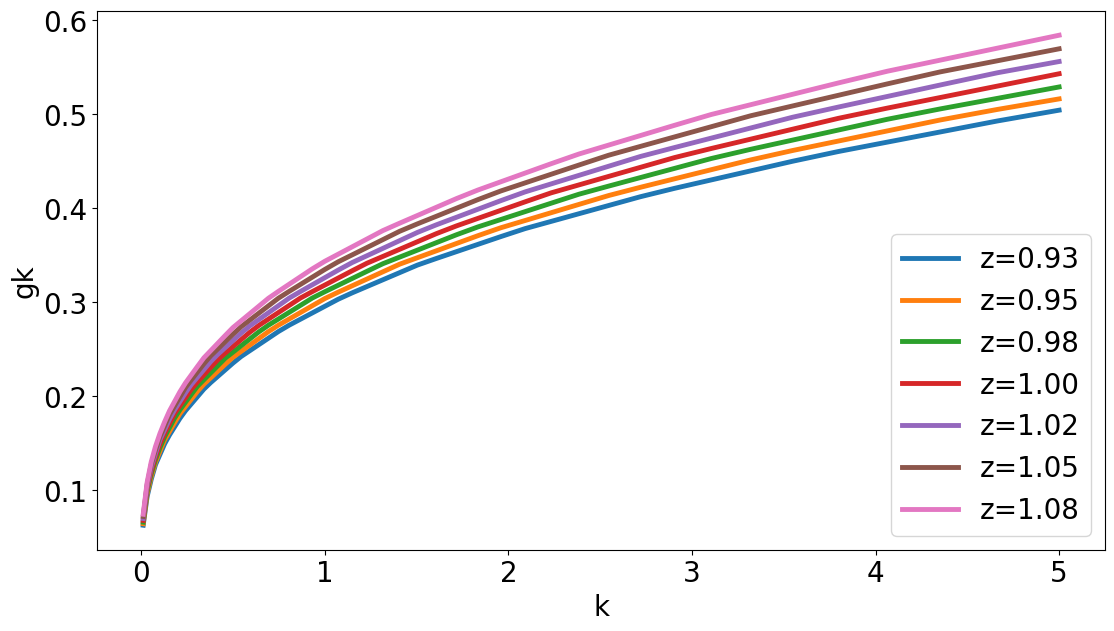

In [15]:
for s, zs in enumerate(z_grid):
    plt.plot(k_grid, gk[s, :], label=f'z={zs:.2f}')
plt.legend()
plt.xlabel('k')
plt.ylabel('gk');

To verify the accuracy of our solution, let's compare it with the analytical solution:

In [16]:
gk_true = alpha * beta * z_grid[:, np.newaxis] * (k_grid[np.newaxis, :] ** alpha)
gc_true = (1 - alpha * beta) * z_grid[:, np.newaxis] * (k_grid[np.newaxis, :] ** alpha)

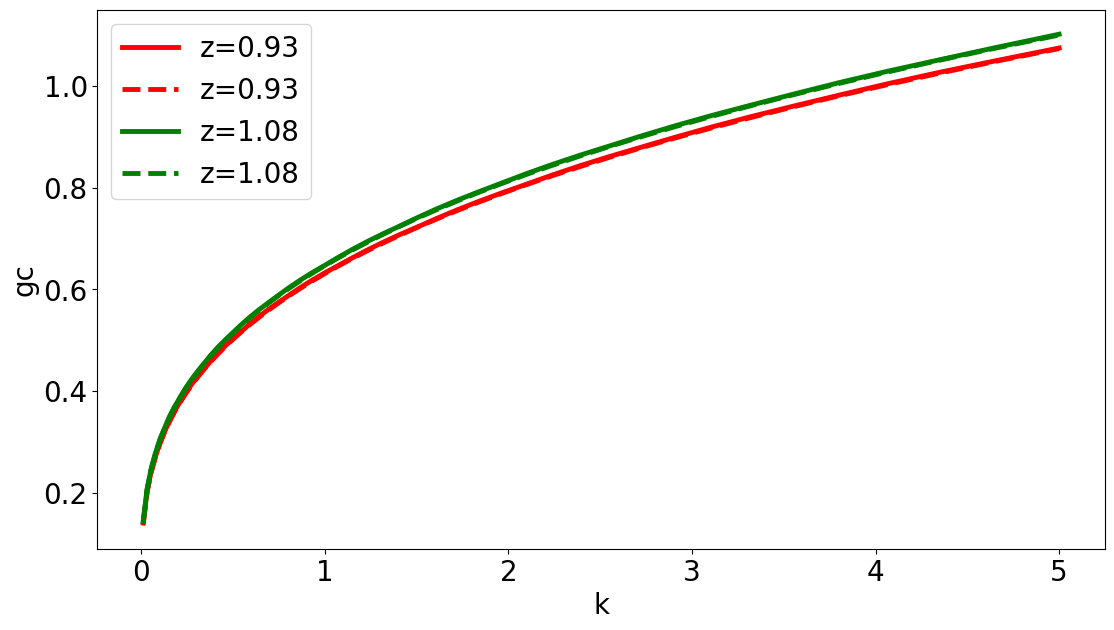

In [17]:
colors = ['r','g']
for s, zs in enumerate(z_grid[0:7:6]):
    plt.plot(k_grid, gc[s, :], label=f'z={zs:.2f}', color = colors[s])
    plt.plot(k_grid, gc_true[s, :], label=f'z={zs:.2f}', linestyle='dashed', color = colors[s])
plt.legend()
plt.xlabel('k')
plt.ylabel('gc');

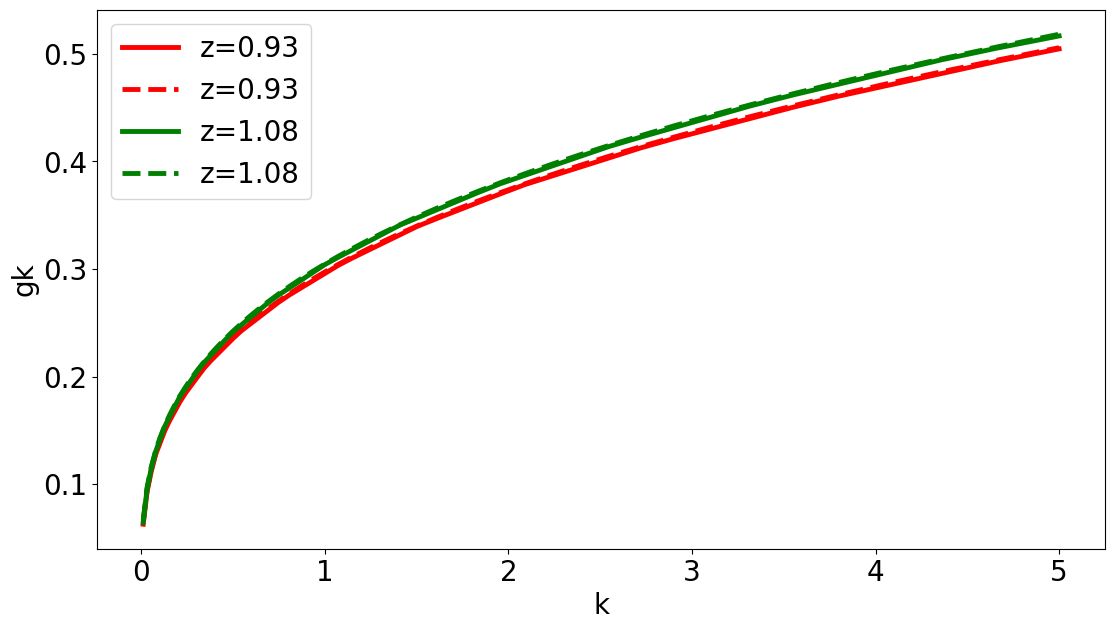

In [18]:
for s, zs in enumerate(z_grid[0:7:6]):
    plt.plot(k_grid, gk[s, :], label=f'z={zs:.2f}', color = colors[s])
    plt.plot(k_grid, gk_true[s, :], label=f'z={zs:.2f}', linestyle='dashed', color = colors[s])
plt.legend()
plt.xlabel('k')
plt.ylabel('gk');

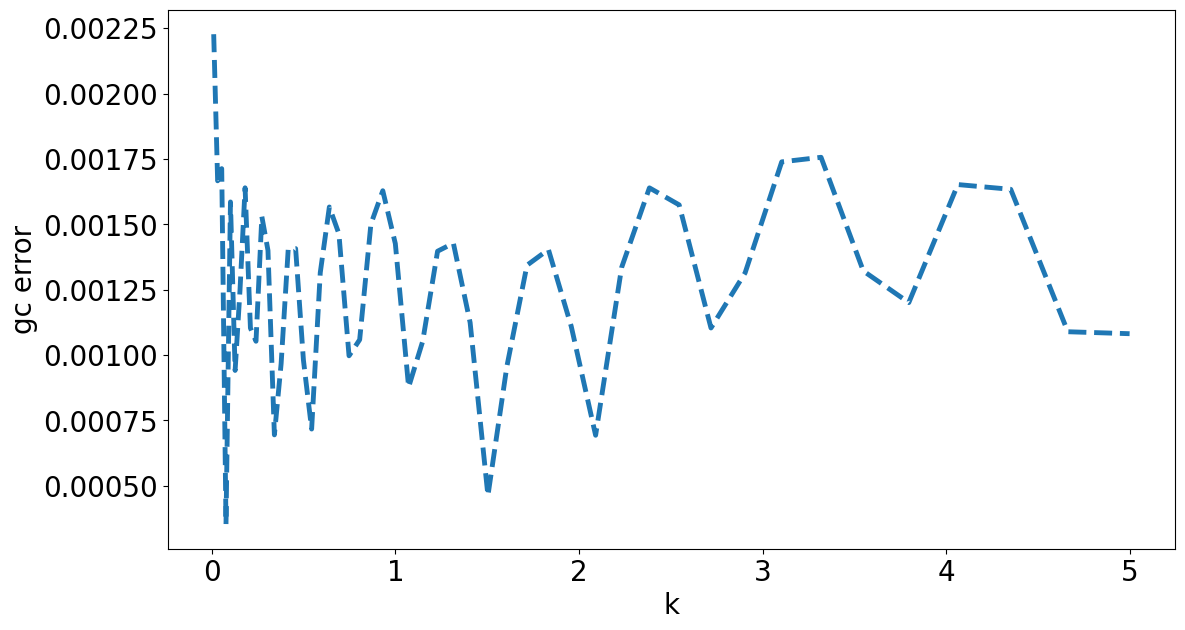

In [18]:
# Consumption policy function error
gc_error = np.abs(gc_true-gc)

for s, zs in enumerate(z_grid[0:1]):
    plt.plot(k_grid, gc_error[s, :], label=f'z={zs:.2f}', linestyle='dashed')
plt.xlabel('k')
plt.ylabel('gc error');

**Advantages**
- Faster than any grid search because it directly exploits the optimality condition.
- Can handle occasionally binding constraints.
- Much more accurate than grid search because (1) the asset policy is not restricted to take values on a grid and (2) directly works with Euler equation.

**Disadvantages**
- Requires concavity and monotonicity so other fast methods are available.
- Not that easy to compute when $\delta\neq 0$.
- Doesn’t generalize naturally to endogenous labor supply, but can be done ([Barillas, F. and Fernández-Villaverde, J. (2007), "A generalization of the endogenous grid method"](https://doi.org/10.1016/j.jedc.2006.08.005)).
- A decent initial guess is required. Generally, an increasing, linear policy works if the slope is not crazy.
- No theorems about convergence.